In [1]:
# importing libraries and functions
import os
import re
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
# Processing manoeuvre and orbital data 

In [3]:
# Helper function for Date conversion
def doy_to_datetime(year: int, doy: int, hour: int, minute: int, second: float=0.0):
    return datetime(year, 1, 1) + timedelta(days=doy - 1, hours=hour, minutes=minute, seconds=second)

In [5]:
# Processing Fengyun manoeuvre file
def parse_fengyun_line(line: str):
    pattern = r'(\S+)\s+(\S+)\s+"([^"]+)"\s+"([^"]+)"'
    match = re.match(pattern, line)
    if not match:
        print(f"Line did not match Fengyun format: {line}")
        return None

    sat_code = match.group(1)
    sat_id = f"{sat_code} {match.group(2)}"
    start_str = match.group(3).split()[0]  
    end_str = match.group(4).split()[0]

    try:
        start_dt = datetime.fromisoformat(start_str)
        end_dt = datetime.fromisoformat(end_str)
    except Exception as e:
        print(f"Error parsing timestamps: {line}\n{e}")
        return None

    return {'satellite': sat_id, 'start_time': start_dt, 'end_time': end_dt}

In [6]:

def process_fengyun_manoeuvre_file(filepath: str):
    records = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = parse_fengyun_line(line)
            if rec:
                records.append(rec)
    return pd.DataFrame(records)

In [7]:
# Processing orbital elements
def load_orbital_elements(filepath: str):
    try:
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        df.sort_index(inplace=True)
        df.index.name = 'timestamp' 
        return df
    except Exception as e:
        print(f"Error loading orbital elements file: {filepath}\n{e}")
        return pd.DataFrame()


In [8]:
def main():
    base_dir = '../satellite_data'
    manoeuvre_file = os.path.join(base_dir, 'manoeuvres', 'manFY2D.txt.fy')
    orbital_file = os.path.join(base_dir, 'orbital_elements', 'Fengyun-2D.csv')


    print(f"Processing Fengyun manoeuvre file: {manoeuvre_file}")
    df_manoeuvre = process_fengyun_manoeuvre_file(manoeuvre_file)
    print("Fengyun manoeuvre data:")
    print(df_manoeuvre.head())

    print(f"Processing Fengyun orbital elements file: {orbital_file}")
    df_orbital = load_orbital_elements(orbital_file)
    print("Fengyun orbital element data:")
    print(df_orbital.head())

    return df_manoeuvre, df_orbital

    return man_df, orb_df 

In [9]:
man_df, orb_df = main()

Processing Fengyun manoeuvre file: ../satellite_data/manoeuvres/manFY2D.txt.fy
Fengyun manoeuvre data:
                          satellite          start_time            end_time
0  GEO-EW-STATION-KEEPING 2006-053A 2015-04-10 15:30:00 2015-04-10 16:30:00
1  GEO-EW-STATION-KEEPING 2006-053A 2015-01-27 14:30:00 2015-01-27 15:30:00
2  GEO-EW-STATION-KEEPING 2006-053A 2014-10-24 15:30:00 2014-10-24 16:30:00
3  GEO-EW-STATION-KEEPING 2006-053A 2014-08-04 15:30:00 2014-08-04 16:30:00
4  GEO-EW-STATION-KEEPING 2006-053A 2014-05-09 15:30:00 2014-05-09 16:30:00
Processing Fengyun orbital elements file: ../satellite_data/orbital_elements/Fengyun-2D.csv
Fengyun orbital element data:
                            eccentricity  argument of perigee  inclination  \
timestamp                                                                    
2011-01-27 14:08:12.153119      0.000146             5.402166     0.020778   
2011-01-28 17:37:05.756160      0.000155             5.423049     0.020839   
2011-01

<Figure size 1000x400 with 0 Axes>

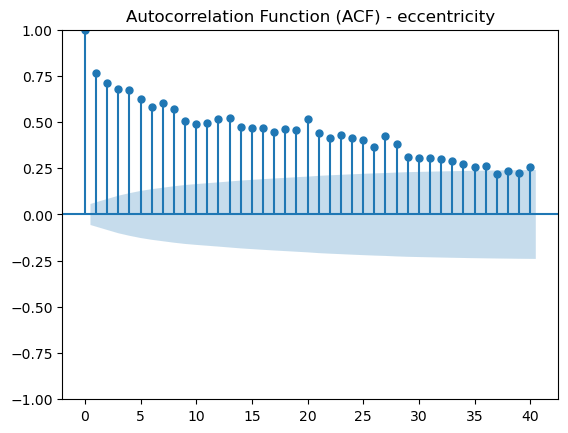

<Figure size 1000x400 with 0 Axes>

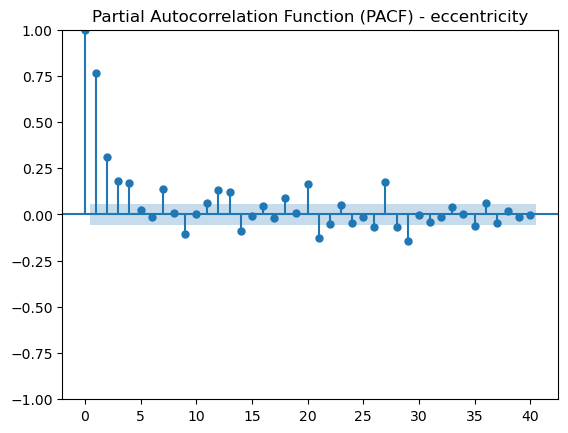

Null Hypothesis (H₀): The time series is non-stationary (contains a unit root).
Alternative Hypothesis (H₁): The time series is stationary (does not contain a unit root).


 ADF Test
ADF Statistic     : -3.218244
p-value           : 0.018953
Critical Values   :
   1%: -3.4360
   5%: -2.8640
   10%: -2.5681

 The series is stationary .

Conclusion: Reject the null hypothesis (H₀). The series is stationary at the 5% significance level.


In [10]:
# EDA for 'eccentricity'

series = orb_df['eccentricity'].dropna()

# ACF plot
plt.figure(figsize=(10, 4))
plot_acf(series, lags=40)
plt.title('Autocorrelation Function (ACF) - eccentricity')
plt.show()

# PACF plot
plt.figure(figsize=(10, 4))
plot_pacf(series, lags=40, method='ywm')  
plt.title('Partial Autocorrelation Function (PACF) - eccentricity')
plt.show()

# ADF Test

# Print hypotheses
print("Null Hypothesis (H₀): The time series is non-stationary (contains a unit root).")
print("Alternative Hypothesis (H₁): The time series is stationary (does not contain a unit root).\n")
result = adfuller(series)
print('\n ADF Test')
print(f"ADF Statistic     : {result[0]:.6f}")
print(f"p-value           : {result[1]:.6f}")
print(f"Critical Values   :")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")
if result[1] < 0.05:
    print("\n The series is stationary .")
else:
    print("\n The series is NOT stationary.")
# Conclusion
if result[1] <= 0.05:
    print("\nConclusion: Reject the null hypothesis (H₀). The series is stationary at the 5% significance level.")
else:
    print("\nConclusion: Fail to reject the null hypothesis (H₀). The series is non-stationary at the 5% significance level.")



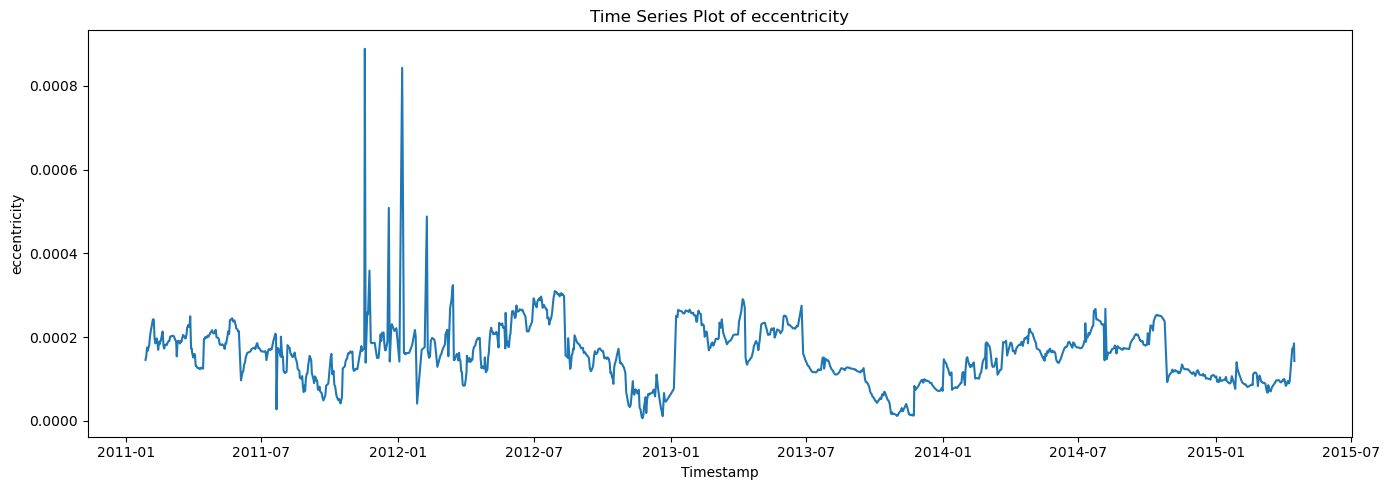

In [11]:
# Pliotting the trend for 'eccentricity'

def plot_eccentricity_trend(df):
    if 'eccentricity' not in df.columns:
        print("Column 'right ascension' not found in dataframe.")
        return
    
    plt.figure(figsize=(14, 5))
    sns.lineplot(x=df.index, y=df['eccentricity'])
    plt.title("Time Series Plot of eccentricity")
    plt.xlabel("Timestamp")
    plt.ylabel("eccentricity")
    plt.tight_layout()
    plt.show()

plot_eccentricity_trend(orb_df)


In [12]:
# Sorting index
orb_df = orb_df.sort_index()
orb_df.index = pd.to_datetime(orb_df.index)

In [13]:
# Resample to daily frequency
ra_daily = orb_df['eccentricity'].resample('D').mean().ffill()
series = ra_daily.dropna()

In [14]:
# Checking stationarity 

In [15]:

#  Fill missing values 
if orb_df['eccentricity'].isna().sum() > 0:
    orb_df['eccentricity'] = orb_df['eccentricity'].fillna(method='ffill')

=== Original eccentricity ===
ADF Statistic: -3.2182
p-value: 0.0190
Result: Stationary




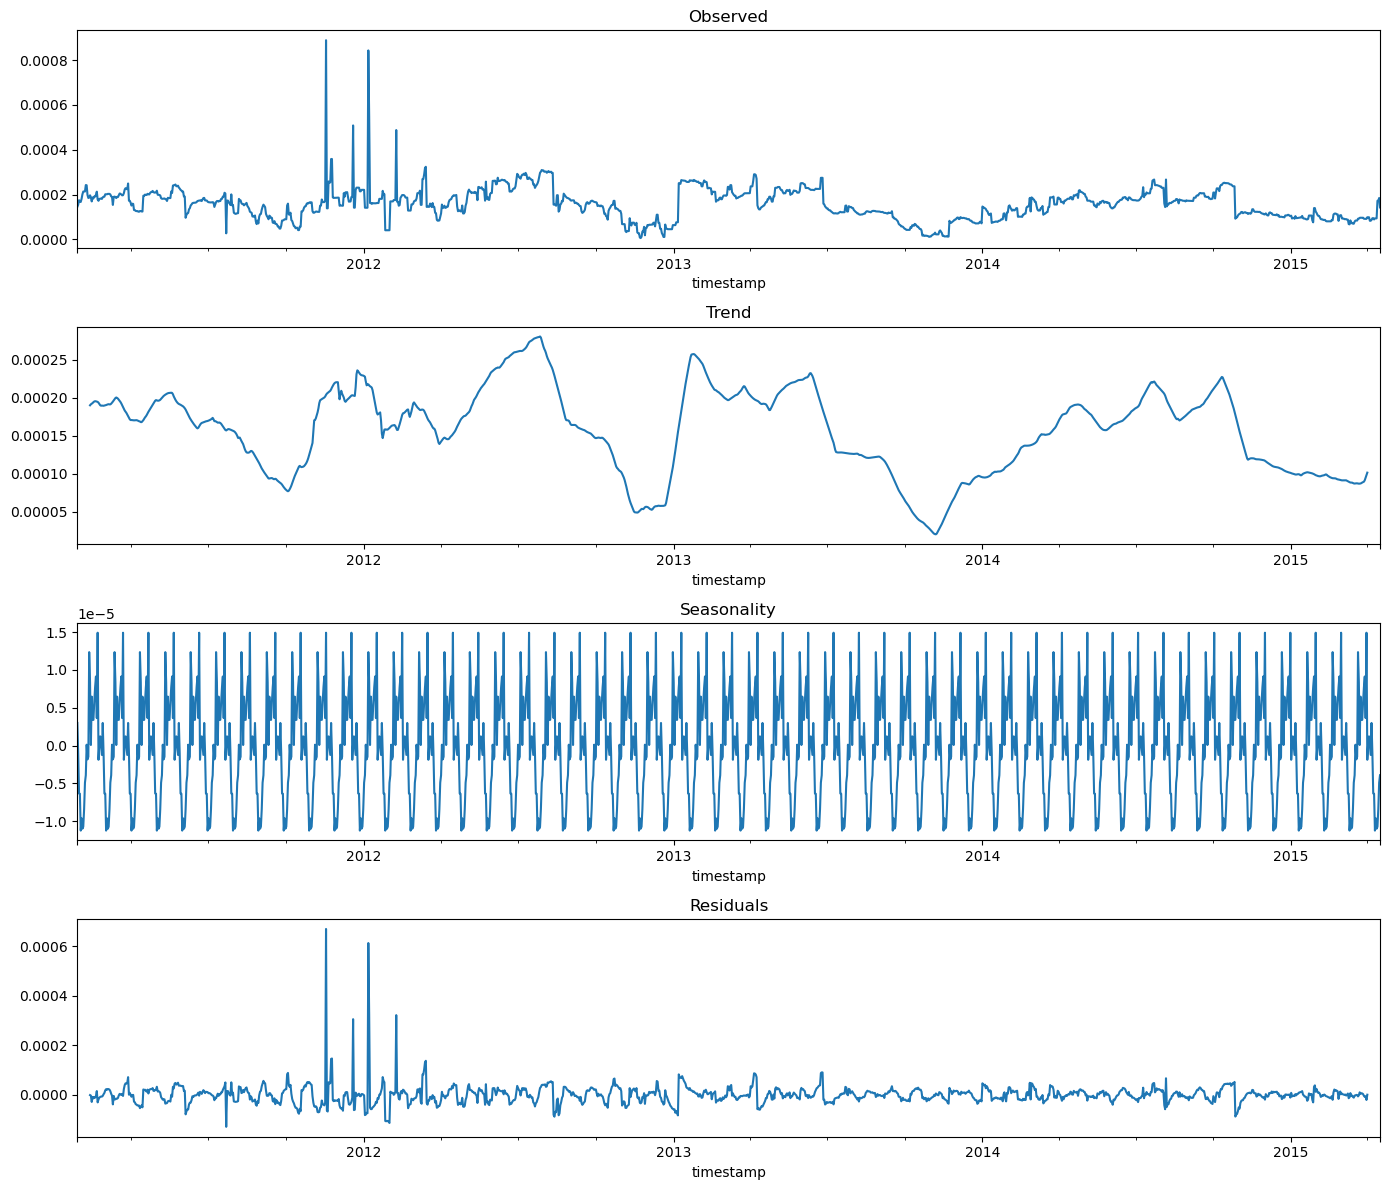

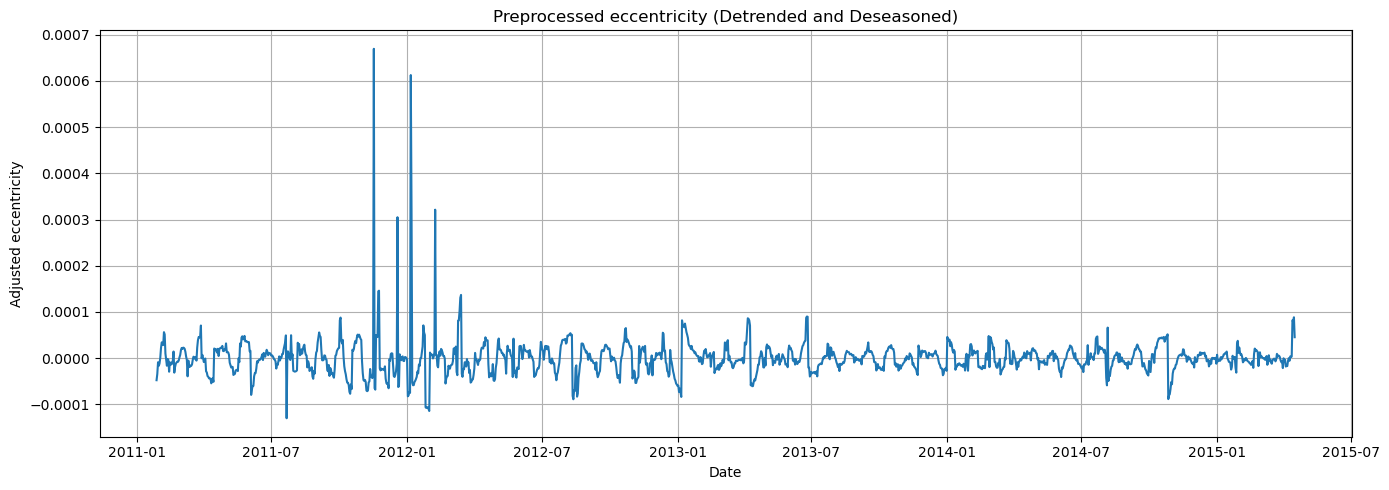

=== Preprocessed Series ===
ADF Statistic: -13.7464
p-value: 0.0000
Result: Stationary




In [16]:
# Stationarity 
def test_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f'=== {title} ===')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Result: {"Stationary" if result[1] < 0.05 else "Non-stationary"}')
    print("\n")
    return result[1] < 0.05

is_stationary = test_stationarity(orb_df['eccentricity'], "Original eccentricity")

eccentricity_daily = orb_df['eccentricity'].resample('D').mean().ffill()

period = 30  
decomposition = seasonal_decompose(eccentricity_daily, model='additive', period=period)

#  Plotting decomposition 
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
plt.show()

# Preprocessing detrend and deseason ---
trend = decomposition.trend.ffill().bfill()
seasonal = decomposition.seasonal.ffill().bfill()
detrended_deseasoned = ra_daily - trend - seasonal

# Plotting preprocessed right ascension
plt.figure(figsize=(14, 5))
plt.plot(detrended_deseasoned.index, detrended_deseasoned.values)
plt.title("Preprocessed eccentricity (Detrended and Deseasoned)")
plt.xlabel("Date")
plt.ylabel("Adjusted eccentricity")
plt.grid(True)
plt.tight_layout()
plt.show()

# Test stationarity of preprocessed data 
is_preprocessed_stationary = test_stationarity(detrended_deseasoned.dropna(), "Preprocessed Series")

preprocessed_data = detrended_deseasoned.dropna()

In [17]:
# Train test split

train_size = int(len(preprocessed_data) * 0.8)
train_data = preprocessed_data[:train_size]
test_data = preprocessed_data[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1232,)
Test data shape: (309,)


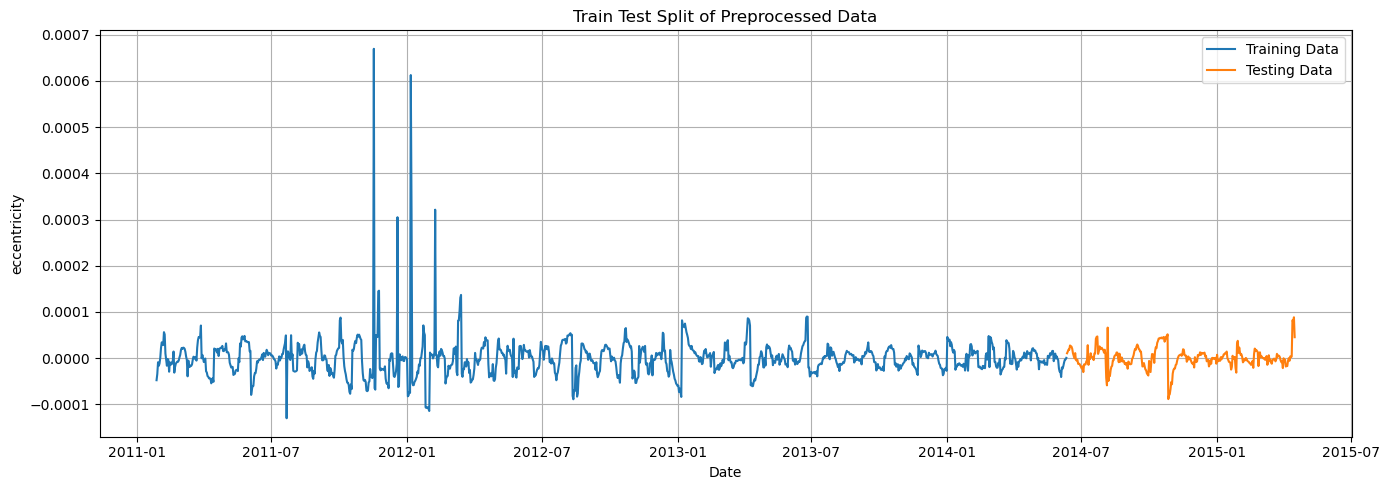

In [18]:
#Plotting the split
plt.figure(figsize=(14, 5))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.title("Train Test Split of Preprocessed Data")
plt.xlabel("Date")
plt.ylabel("eccentricity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Grid search

def grid_search_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_aic = float("inf")
    results = []

    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)
                    model_fit = model.fit()
                    aic = model_fit.aic

                    # Store results
                    results.append({
                        'order': (p, d, q),
                        'aic': aic
                    })

                    if aic < best_aic:
                        best_aic = aic
                        best_cfg = (p, d, q)

                    print(f"ARIMA({p},{d},{q}) - AIC: {aic:.4f}")
                except Exception as e:
                    print(f"Error with ARIMA({p},{d},{q}): {str(e)}")
                    continue

    warnings.filterwarnings("default", category=ConvergenceWarning) 
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('aic')
        print("\nTop 5 ARIMA Models:")
        print(results_df.head())

    print(f"\nBest ARIMA Model: {best_cfg} with AIC: {best_aic:.4f}")
    return best_cfg

# Define parameter ranges
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

best_order = grid_search_arima(train_data, p_values, d_values, q_values)


ARIMA(0,0,0) - AIC: -21249.6849
ARIMA(0,0,1) - AIC: -21433.2078
ARIMA(0,0,2) - AIC: -21424.7585
ARIMA(0,0,3) - AIC: -21428.4944
ARIMA(0,1,0) - AIC: -21028.9993
ARIMA(0,1,1) - AIC: -21225.9745
ARIMA(0,1,2) - AIC: -21230.2811
ARIMA(0,1,3) - AIC: -21219.4661
ARIMA(0,2,0) - AIC: -19815.8735
ARIMA(0,2,1) - AIC: -20715.3537
ARIMA(0,2,2) - AIC: -20723.4505
ARIMA(0,2,3) - AIC: -20838.7488
ARIMA(1,0,0) - AIC: -21481.5438
ARIMA(1,0,1) - AIC: -21463.1020
ARIMA(1,0,2) - AIC: -21445.2754
ARIMA(1,0,3) - AIC: -21429.7115
ARIMA(1,1,0) - AIC: -21161.7061
ARIMA(1,1,1) - AIC: -21253.3260
ARIMA(1,1,2) - AIC: -21266.9014
ARIMA(1,1,3) - AIC: -21252.2830
ARIMA(1,2,0) - AIC: -20289.8555
ARIMA(1,2,1) - AIC: -20765.7434
ARIMA(1,2,2) - AIC: -20753.8775
ARIMA(1,2,3) - AIC: -20858.3226
ARIMA(2,0,0) - AIC: -21462.5293
ARIMA(2,0,1) - AIC: -19381.9207
ARIMA(2,0,2) - AIC: -21447.4618
ARIMA(2,0,3) - AIC: -21427.7783
ARIMA(2,1,0) - AIC: -21240.7168
ARIMA(2,1,1) - AIC: -21281.1470
ARIMA(2,1,2) - AIC: -21295.6673
ARIMA(2,

In [20]:
# Training on training data

best_model = ARIMA(train_data, order=best_order)
best_model_fit = best_model.fit()
print("Best model summary:")
print(best_model_fit.summary())

# Make predictions on test data
predictions = best_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.8f}")


# Make future predictions
future_steps = 30 
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_forecast = best_model_fit.forecast(steps=future_steps)


Best model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1232
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10752.296
Date:                Fri, 15 Aug 2025   AIC                         -21498.593
Time:                        13:50:48   BIC                         -21483.243
Sample:                    01-27-2011   HQIC                        -21492.818
                         - 06-11-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.999e-08   2.48e-06     -0.040      0.968   -4.96e-06    4.76e-06
ar.L1          0.4011   5.53e-10   7.26e+08      0.000       0.401       0.401
sigma2      1.537e-09   1.88e-11

/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Recompose the predictions and future forecasts back into original scale

def recompose_series(decomposed_values, trend_series, seasonal_series, dates):
    recomposed = []
    for i, date in enumerate(dates):
      
        trend_value = trend_series.get(date, trend_series.iloc[-1] if date > trend_series.index[-1] else trend_series.iloc[0])
        seasonal_idx = (i % len(seasonal_series)) if len(seasonal_series) > 0 else 0
        seasonal_value = seasonal_series.iloc[seasonal_idx]
        
        
        recomposed_value = decomposed_values[i] + trend_value + seasonal_value
        recomposed.append(recomposed_value)
    
    return recomposed

recomposed_test_dates = test_data.index
recomposed_future_dates = future_index


test_trend = trend.reindex(recomposed_test_dates, method='nearest')
test_seasonal_pattern = seasonal.iloc[:len(seasonal)]  


future_trend = pd.Series([trend.iloc[-1]] * len(future_index), index=future_index)


recomposed_predictions = recompose_series(
    predictions.values, 
    test_trend, 
    test_seasonal_pattern, 
    recomposed_test_dates
)


recomposed_future = recompose_series(
    future_forecast, 
    future_trend, 
    test_seasonal_pattern, 
    recomposed_future_dates
)


/var/folders/79/rslv5fq135sbn0bs88sx99680000gn/T/ipykernel_96304/1767691503.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recomposed_value = decomposed_values[i] + trend_value + seasonal_value


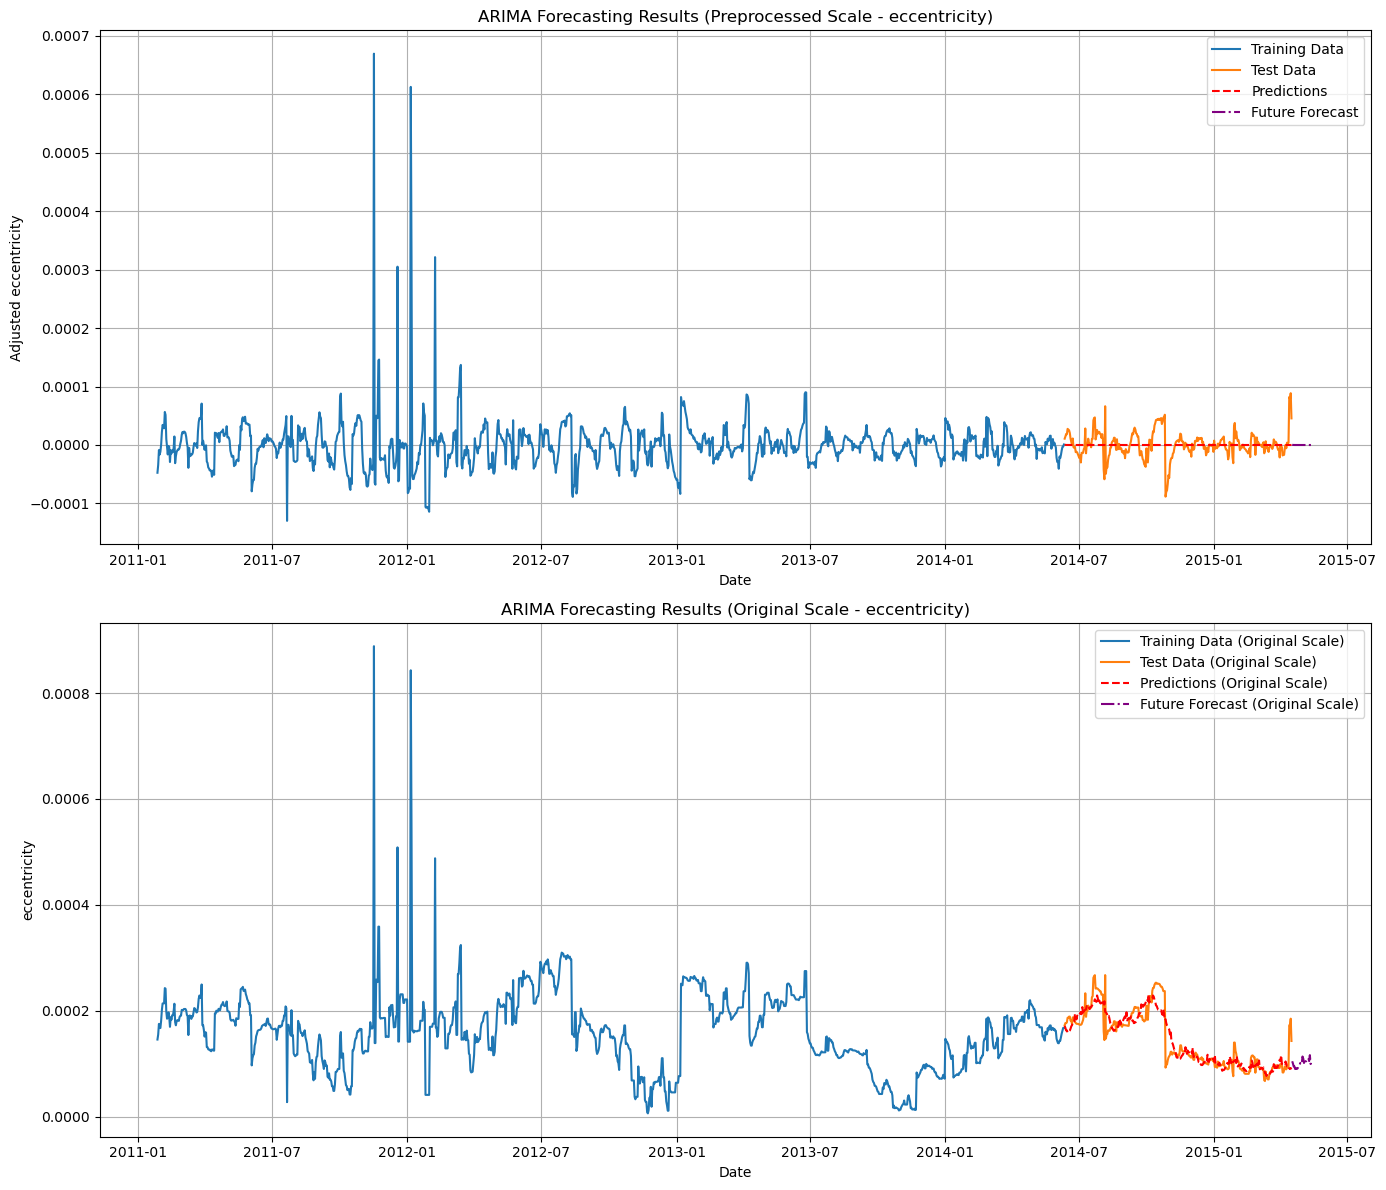

In [22]:
# Plotting original scale and the preprocessed scale

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plotting Preprocessed scale 
axes[0].plot(train_data.index, train_data, label='Training Data')
axes[0].plot(test_data.index, test_data, label='Test Data')
axes[0].plot(test_data.index, predictions, label='Predictions', color='red', linestyle='--')
axes[0].plot(future_index, future_forecast, label='Future Forecast', color='purple', linestyle='-.')
axes[0].set_title("ARIMA Forecasting Results (Preprocessed Scale - eccentricity)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Adjusted eccentricity")
axes[0].legend()
axes[0].grid(True)

# Plotting Original scale 
axes[1].plot(eccentricity_daily.index[:train_size], eccentricity_daily.iloc[:train_size], 
             label='Training Data (Original Scale)')
axes[1].plot(test_data.index, eccentricity_daily.reindex(test_data.index), 
             label='Test Data (Original Scale)')
axes[1].plot(test_data.index, recomposed_predictions, 
             label='Predictions (Original Scale)', color='red', linestyle='--')
axes[1].plot(future_index, recomposed_future, 
             label='Future Forecast (Original Scale)', color='purple', linestyle='-.')
axes[1].set_title("ARIMA Forecasting Results (Original Scale - eccentricity)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("eccentricity")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [23]:
# residuals

In [24]:
# Calculate residuals (difference between forecasts and actual values)
test_predictions = best_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
residuals = test_data - test_predictions

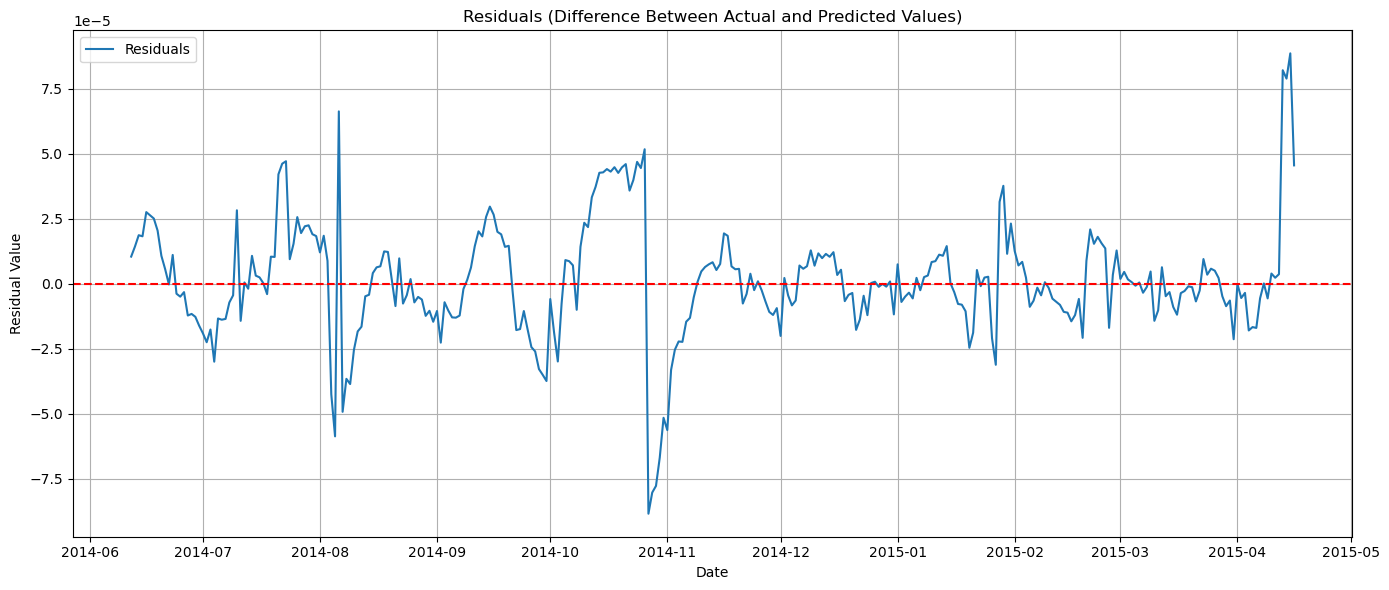

In [25]:
# Plotting the residuals
plt.figure(figsize=(14, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals (Difference Between Actual and Predicted Values)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
#Implementing manoeuvre detection

# absolute residuals
abs_residuals = np.abs(residuals)

# Determine threshold using std
threshold_std = abs_residuals.mean() + 2 * abs_residuals.std()
threshold = threshold_std 

# Detecting potential manoeuvres
detected_manoeuvres = residuals[abs_residuals > threshold]

print(f"Threshold value: {threshold:.8f}")
print(f"Number of detected manoeuvres: {len(detected_manoeuvres)}")

Threshold value: 0.00004739
Number of detected manoeuvres: 13


In [27]:


# Group consecutive detected points (within 1-2 days) as single manoeuvre events
# Convert index to list for processing
detected_dates = detected_manoeuvres.index.tolist()
manoeuvre_events = []

if detected_dates:
    current_event = [detected_dates[0]]
    
    for i in range(1, len(detected_dates)):
        # If current date is within 2 days of the last date in current event
        if (detected_dates[i] - current_event[-1]).days <= 2:  
            current_event.append(detected_dates[i])
        else:
            # End of current event, start a new one
            manoeuvre_events.append({
                'start_time': current_event[0],
                'end_time': current_event[-1],
                'max_residual': abs_residuals[current_event].max()
            })
            current_event = [detected_dates[i]]
    
    # Add the last event
    manoeuvre_events.append({
        'start_time': current_event[0],
        'end_time': current_event[-1],
        'max_residual': abs_residuals[current_event].max()
    })

# Convert to DataFrame
detected_df = pd.DataFrame(manoeuvre_events)


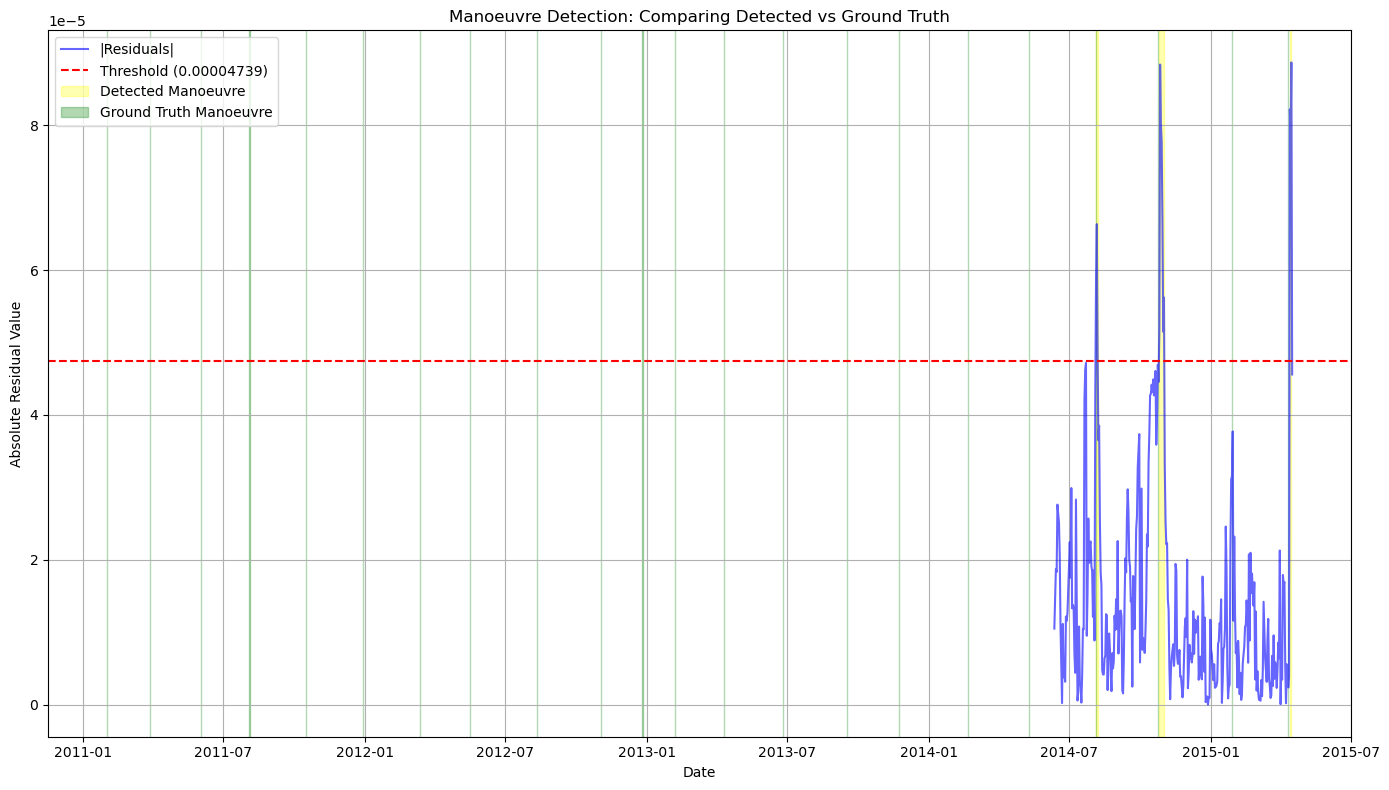

In [28]:
#  Plotting detected manoeuvres against ground truth

plt.figure(figsize=(14, 8))

# absolute residuals
plt.plot(abs_residuals.index, abs_residuals, label='|Residuals|', color='blue', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.8f})')

# detected manoeuvres
for idx, event in enumerate(manoeuvre_events):
    plt.axvspan(event['start_time'], event['end_time'], 
                alpha=0.3, color='yellow', label='Detected Manoeuvre' if idx == 0 else '')

# ground truth manoeuvres
for idx, row in man_df.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], 
                alpha=0.3, color='green', label='Ground Truth Manoeuvre' if idx == 0 else '')

plt.title('Manoeuvre Detection: Comparing Detected vs Ground Truth')
plt.xlabel('Date')
plt.ylabel('Absolute Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Calculate accuracy metrics

In [30]:
def calculate_detection_accuracy(detected_df, ground_truth_df, tolerance_days=3):
    true_positives = 0
    false_positives = 0
    
    for _, det_event in detected_df.iterrows():
        matched = False
        for _, gt_event in ground_truth_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break
        if matched:
            true_positives += 1
        else:
            false_positives += 1
    
    # Count false negatives
    false_negatives = 0
    for _, gt_event in ground_truth_df.iterrows():
        matched = False
        for _, det_event in detected_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or
                
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break     
        if not matched:
            false_negatives += 1
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }


In [31]:
# Calculate and display detection accuracy metrics
accuracy_metrics = calculate_detection_accuracy(detected_df, man_df)
print("\nManoeuvre Detection Performance:")
print(f"True Positives: {accuracy_metrics['true_positives']}")
print(f"False Positives: {accuracy_metrics['false_positives']}")
print(f"False Negatives: {accuracy_metrics['false_negatives']}")
print(f"Precision: {accuracy_metrics['precision']:.4f}")
print(f"Recall: {accuracy_metrics['recall']:.4f}")
print(f"F1 Score: {accuracy_metrics['f1_score']:.4f}")

# Printing detected vs ground truth manoeuvres
print("\nDetected Manoeuvres:")
print(detected_df[['start_time', 'end_time', 'max_residual']])

print("\nGround Truth Manoeuvres:")
print(man_df[['start_time', 'end_time']])


Manoeuvre Detection Performance:
True Positives: 3
False Positives: 0
False Negatives: 19
Precision: 1.0000
Recall: 0.1364
F1 Score: 0.2400

Detected Manoeuvres:
  start_time   end_time  max_residual
0 2014-08-05 2014-08-07      0.000066
1 2014-10-26 2014-11-01      0.000088
2 2015-04-13 2015-04-15      0.000089

Ground Truth Manoeuvres:
            start_time            end_time
0  2015-04-10 15:30:00 2015-04-10 16:30:00
1  2015-01-27 14:30:00 2015-01-27 15:30:00
2  2014-10-24 15:30:00 2014-10-24 16:30:00
3  2014-08-04 15:30:00 2014-08-04 16:30:00
4  2014-05-09 15:30:00 2014-05-09 16:30:00
5  2014-02-20 15:30:00 2014-02-20 16:30:00
6  2013-11-22 15:30:00 2013-11-22 16:30:00
7  2013-09-16 15:30:00 2013-09-16 16:30:00
8  2013-06-25 15:30:00 2013-06-25 16:30:00
9  2013-04-09 15:30:00 2013-04-09 16:30:00
10 2013-02-05 15:30:00 2013-02-05 16:30:00
11 2012-12-25 11:00:00 2012-12-26 15:00:00
12 2012-11-01 09:30:00 2012-11-01 10:30:00
13 2012-08-10 15:00:00 2012-08-10 16:00:00
14 2012-05-16 

In [41]:
# Quantitative metrics
def calculate_accuracy(detected_df, ground_truth_df, total_possible_events, tolerance_days=3):
    true_positives = 0
    false_positives = 0

   
    for _, det_event in detected_df.iterrows():
        matched = False
        for _, gt_event in ground_truth_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break
        
        if matched:
            true_positives += 1
        else:
            false_positives += 1


    false_negatives = 0
    for _, gt_event in ground_truth_df.iterrows():
        matched = False
        for _, det_event in detected_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or            
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break  
        if not matched:
            false_negatives += 1


    true_negatives = total_possible_events - (true_positives + false_positives + false_negatives)

    # Calculating metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (true_positives + true_negatives) / total_possible_events if total_possible_events > 0 else 0

    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_negatives': true_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy
    }


total_possible_events = 109 

accuracy_metrics = calculate_accuracy(detected_df, man_df, total_possible_events)

# Printing all the detection accuracy metrics
print("\nManoeuvre Detection Performance:")
print(f"True Positives: {accuracy_metrics['true_positives']}")
print(f"False Positives: {accuracy_metrics['false_positives']}")
print(f"False Negatives: {accuracy_metrics['false_negatives']}")
print(f"True Negatives: {accuracy_metrics['true_negatives']}")
print(f"Precision: {accuracy_metrics['precision']:.4f}")
print(f"Recall: {accuracy_metrics['recall']:.4f}")
print(f"F1 Score: {accuracy_metrics['f1_score']:.4f}")
print(f"Accuracy: {accuracy_metrics['accuracy']:.4f}")



Manoeuvre Detection Performance:
True Positives: 3
False Positives: 0
False Negatives: 19
True Negatives: 87
Precision: 1.0000
Recall: 0.1364
F1 Score: 0.2400
Accuracy: 0.8257


/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


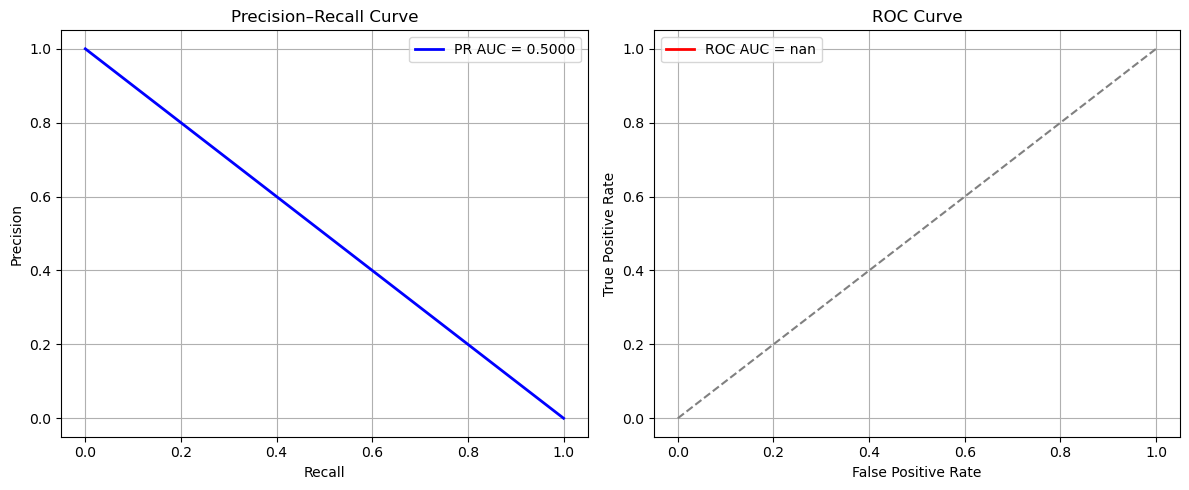

In [33]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

ground_truth_labels = []
for date in abs_residuals.index:
    in_manoeuvre = any(
        (date >= row['start_time']) and (date <= row['end_time'])
        for _, row in man_df.iterrows()
    )
    ground_truth_labels.append(1 if in_manoeuvre else 0)

scores = abs_residuals.values

# Compute Precision Recall curve
precision, recall, pr_thresholds = precision_recall_curve(ground_truth_labels, scores)
pr_auc = auc(recall, precision)

# Compute ROC 
fpr, tpr, roc_thresholds = roc_curve(ground_truth_labels, scores)
roc_auc_value = auc(fpr, tpr)

# Plot Precision Recall curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC AUC = {roc_auc_value:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


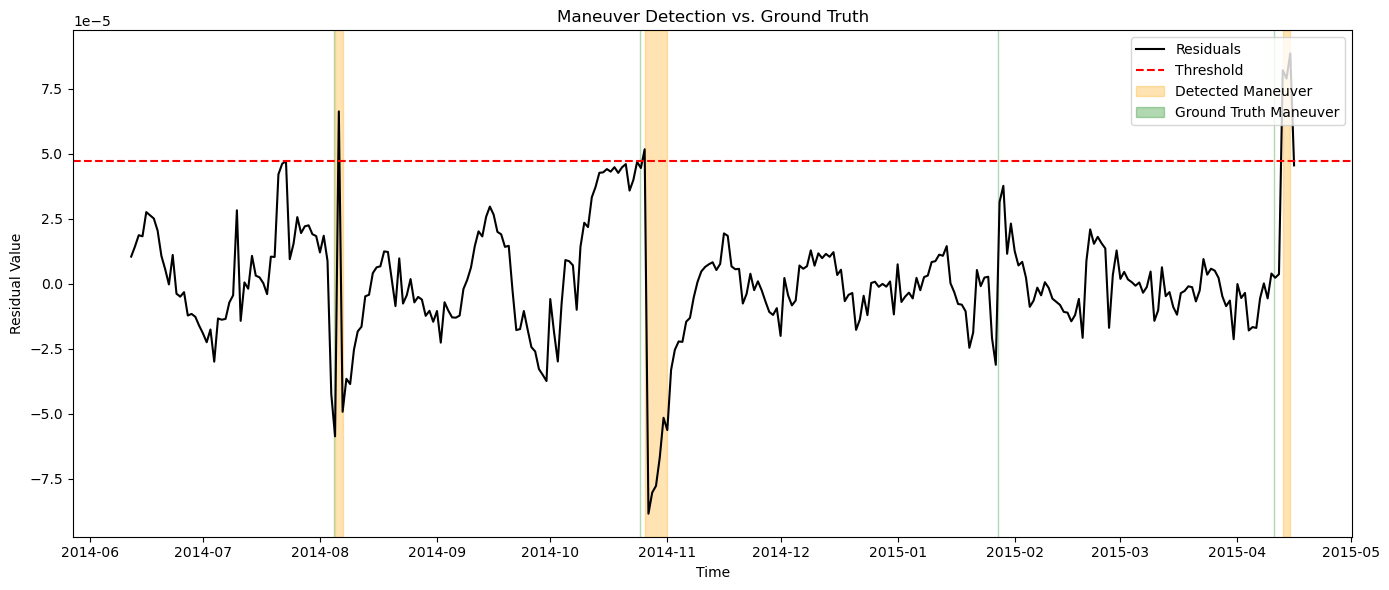

In [34]:
# Filter ground truth maneuvers to match residuals time window
man_df_filtered = man_df[
    (man_df['start_time'] >= residuals.index.min()) &
    (man_df['end_time'] <= residuals.index.max())
]

plt.figure(figsize=(14, 6))

# residuals
plt.plot(residuals.index, residuals.values, label='Residuals', color='black')

# threshold 
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# detected maneuvers
if not detected_df.empty:
    for idx, row in detected_df.iterrows():
        plt.axvspan(row['start_time'], row['end_time'], color='orange', alpha=0.3,
                    label='Detected Maneuver' if idx == 0 else "")

# ground truth maneuvers
if not man_df_filtered.empty:
    for idx, row in man_df_filtered.iterrows():
        plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3,
                    label='Ground Truth Maneuver' if idx == 0 else "")

plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.title('Maneuver Detection vs. Ground Truth')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [35]:
def detect_anomalies(residuals, threshold):
    anomalies = []
    in_anomaly = False
    start_time = None

    for time, value in residuals.items():
        if abs(value) > threshold:
            if not in_anomaly:
                in_anomaly = True
                start_time = time
        else:
            if in_anomaly:
                in_anomaly = False
                end_time = time
                anomalies.append({'start_time': start_time, 'end_time': end_time})
    if in_anomaly:
        anomalies.append({'start_time': start_time, 'end_time': residuals.index[-1]})
    
    return pd.DataFrame(anomalies)


In [36]:
def plot_anomaly_detection(observed, predicted, residuals, threshold, man_df):
    detected_df = detect_anomalies(residuals, threshold)
    man_df_filtered = man_df[
        (man_df['start_time'] >= residuals.index.min()) &
        (man_df['end_time'] <= residuals.index.max())
    ]

    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Observed vs Predicted
    axs[0].plot(observed.index, observed.values, label='Observed', color='blue')
    axs[0].plot(predicted.index, predicted.values, label='Predicted', color='orange')
    axs[0].set_ylabel('Signal')
    axs[0].set_title('Observed vs Predicted')
    axs[0].legend(loc='upper right')

    # Residuals with anomalies
    axs[1].plot(residuals.index, residuals.values, label='Residuals', color='black')
    axs[1].axhline(y=threshold, color='red', linestyle='--', label='Threshold')
    axs[1].axhline(y=-threshold, color='red', linestyle='--')

    for idx, row in detected_df.iterrows():
        axs[1].axvspan(row['start_time'], row['end_time'], color='orange', alpha=0.3,
                       label='Detected Anomaly' if idx == 0 else "")
    
    axs[1].set_ylabel('Residuals')
    axs[1].set_title('Residuals and Detected Anomalies')
    axs[1].legend(loc='upper right')

    # Ground Truth Maneuvers
    axs[2].plot(residuals.index, residuals.values, label='Residuals', color='gray')
    for idx, row in man_df_filtered.iterrows():
        axs[2].axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3,
                       label='Ground Truth Maneuver' if idx == 0 else "")
    axs[2].set_ylabel('Residuals')
    axs[2].set_title('Ground Truth Maneuvers')
    axs[2].legend(loc='upper right')

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()


In [37]:
def detect_anomalies(residuals, threshold):
    anomaly_mask = residuals.abs() > threshold
    return residuals[anomaly_mask]

def plot_all_in_one(observed, predicted, residuals, threshold, man_df):
    anomalies = detect_anomalies(residuals, threshold)

    fig, ax = plt.subplots(figsize=(16, 6))

    # Observed & Predicted
    ax.plot(observed.index, observed.values, label='Observed', color='blue', linewidth=1.5)
    ax.plot(predicted.index, predicted.values, label='Predicted', color='orange', linewidth=1.5)

    # residuals
    ax.plot(residuals.index, residuals.values, color='grey', alpha=0.4, label='Residuals')

    # Anomalies
    ax.scatter(anomalies.index, observed.loc[anomalies.index], color='red', s=60, label='Detected Anomaly', zorder=5)

    # threshold 
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=-threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)

    #Ground Truth Maneuvers
    for idx, row in man_df.iterrows():
        ax.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.2,
                   label='Ground Truth Maneuver' if idx == 0 else "")

    ax.set_title("Anomaly Detection with Ground Truth")
    ax.set_xlabel("Time")
    ax.set_ylabel("Signal Value")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


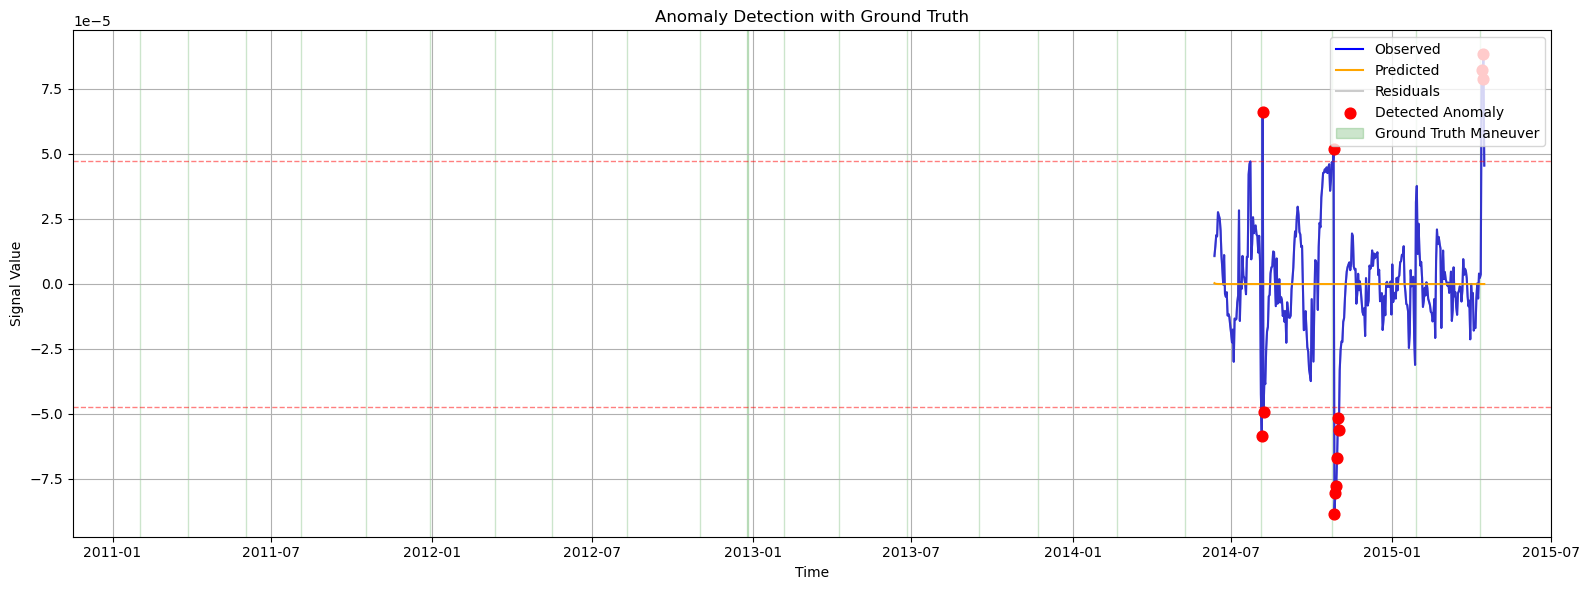

In [38]:
plot_all_in_one(test_data, test_predictions, residuals, threshold, man_df)

In [39]:
def plot_focused_anomalies(observed, predicted, residuals, threshold, man_df):
    valid_times = residuals.dropna().index
    valid_man = man_df[
        (man_df['end_time'] >= valid_times.min()) &
        (man_df['start_time'] <= valid_times.max())
    ]

    # start and end time for plotting
    plot_start = max(valid_times.min(), predicted.dropna().index.min())
    plot_end = max(valid_times.max(), predicted.dropna().index.max())

    # Filter all data 
    observed = observed[(observed.index >= plot_start) & (observed.index <= plot_end)]
    predicted = predicted[(predicted.index >= plot_start) & (predicted.index <= plot_end)]
    residuals = residuals[(residuals.index >= plot_start) & (residuals.index <= plot_end)]
    anomalies = detect_anomalies(residuals, threshold)
    anomalies = anomalies[(anomalies.index >= plot_start) & (anomalies.index <= plot_end)]
    valid_man = valid_man[
        (valid_man['start_time'] <= plot_end) &
        (valid_man['end_time'] >= plot_start)
    ]

    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(observed.index, observed.values, label='Observed', color='blue', linewidth=1.5)
    ax.plot(predicted.index, predicted.values, label='Predicted', color='orange', linewidth=1.5)
    ax.plot(residuals.index, residuals.values, color='grey', alpha=0.5, label='Residuals')

    # Detected anomalies
    ax.scatter(anomalies.index, observed.loc[anomalies.index], color='red', s=60, label='Detected Anomaly', zorder=5)

    # Residual threshold 
    ax.axhline(threshold, linestyle='--', color='red', alpha=0.5)
    ax.axhline(-threshold, linestyle='--', color='red', alpha=0.5)

    # Ground truth 
    for idx, row in valid_man.iterrows():
        ax.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.2,
                   label='Ground Truth Maneuver' if idx == valid_man.index[0] else "")

    ax.set_title("Focused Anomaly Detection: Residuals + Ground Truth/Prediction")
    ax.set_xlabel("Time")
    ax.set_ylabel("Signal Value")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


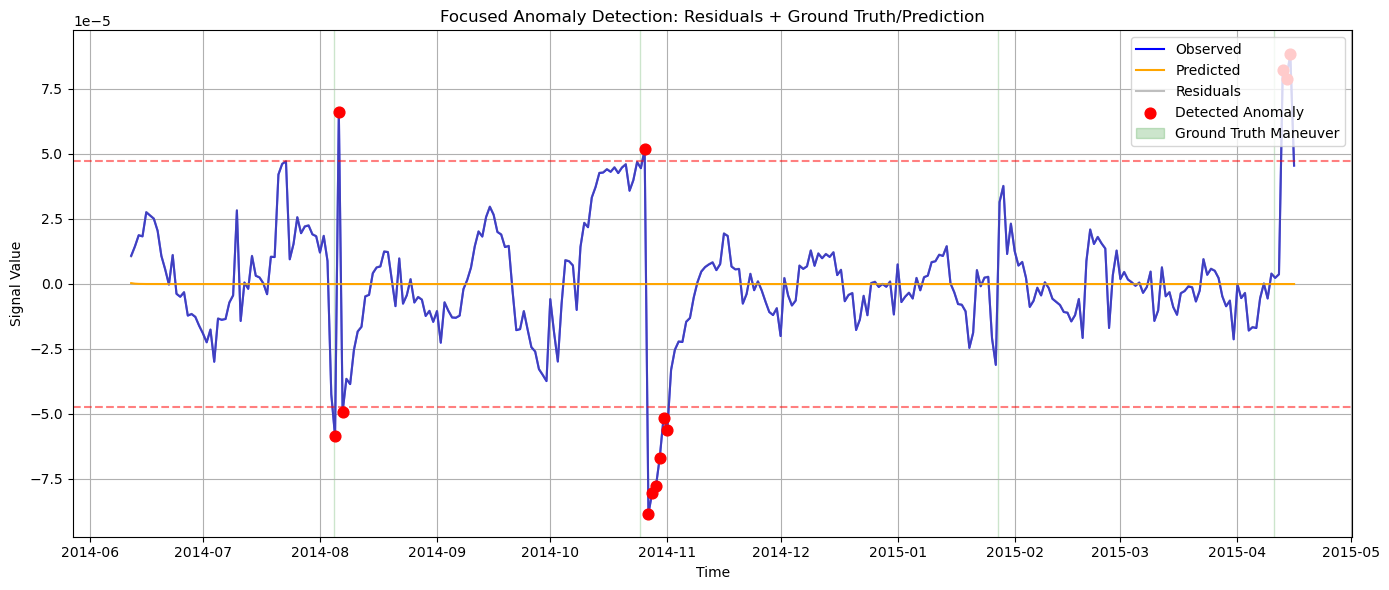

In [40]:
plot_focused_anomalies(test_data, test_predictions, residuals, threshold, man_df)